# Quickstart: Amortized Posterior Estimation

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ensure the backend is set
import os
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import keras

# for BayesFlow devs: this ensures that the latest dev version can be found
import sys
sys.path.append('../')

import bayesflow as bf
from bayesflow.diagnostics.plot_losses import plot_losses
from bayesflow.diagnostics.plot_recovery import plot_recovery

## Generative Model Definition

The toy Gaussian model we will use for this tutorial takes a particularly simple form:

\begin{align}
    \mathbf{\mu} &\sim \mathcal{N}_D(\mathbf{0}, \sigma_0 \mathbb{I}),\\
    \mathbf{x}_n &\sim \mathcal{N}_D(\mathbf{\mu}, \sigma_1 \mathbb{I}) \quad \text{for } n = 1, ..., N,
\end{align}

where $\mathcal{N}_D$
denotes a multivariate Gaussian (normal) density with $D$
dimensions, which we set at $D = 4$
for the current example. For simplicity, we will also set $\sigma_0 = 1$
and $\sigma_1 = 1$
. We will now implement this model using the latest numpy interface.

In [38]:
def theta_prior():
    theta = np.random.normal(size=4)
    return dict(theta=theta)

def forward_model(theta, n_obs=100):
    x = np.random.normal(loc=theta, size=(n_obs, theta.shape[0]))
    return dict(x=x)

In [39]:
simulator = bf.simulators.CompositeLambdaSimulator([theta_prior, forward_model])

In [40]:
sample_data = simulator.sample((50,))

In [41]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['theta', 'x'])
Types of sample_data values:
	 {'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'theta': (50, 4), 'x': (50, 100, 4)}


In [43]:
sample_data

{'theta': array([[ 0.34066415, -0.5138845 ,  1.4528089 , -0.49958685],
        [ 0.86015004,  0.48635587,  0.2364767 , -0.53709507],
        [-0.6582664 , -0.1106401 , -0.5822995 ,  0.29959023],
        [ 0.17613287,  0.40979308, -1.1803418 ,  0.7906092 ],
        [-2.5815134 , -0.5926008 , -1.442977  , -1.1212678 ],
        [ 0.15085632,  0.8538437 , -0.71999   , -0.6779198 ],
        [-0.04969181,  0.45948943,  0.6696255 ,  0.9931811 ],
        [ 1.015672  ,  0.28774238,  0.18076487, -0.11111598],
        [-0.7719207 , -1.3176122 ,  0.5294132 ,  0.4176514 ],
        [ 0.03191099, -0.6768063 ,  0.5141813 , -1.592261  ],
        [-0.99575025, -1.8044442 ,  0.56740063, -1.9281672 ],
        [ 0.81070745, -0.60243636, -0.10667904, -0.3417887 ],
        [ 1.0685011 , -1.3776896 ,  1.8168131 , -0.8139481 ],
        [ 0.01134184,  0.02382061,  1.6661643 , -0.46634912],
        [-1.8478132 , -0.08229433, -0.04664409, -0.11284911],
        [ 1.4040706 , -0.67715555, -0.2592975 , -0.20792411],

In [44]:
data_adapter = bf.ContinuousApproximator.build_data_adapter(
    inference_variables=["theta"],
    inference_conditions=["x"]
)

In [45]:
# Define hyperparameters
num_training_batches = 1024
num_validation_batches = 256
batch_size = 128

In [69]:
training_samples = simulator.sample((num_training_batches * batch_size, ))
validation_samples = simulator.sample((num_validation_batches * batch_size, ))

training_dataset = bf.datasets.OnlineDataset(
    simulator=simulator, 
    batch_size=batch_size, 
    num_batches=num_training_batches, 
    data_adapter=data_adapter
)

validation_dataset = bf.datasets.OnlineDataset(
    simulator=simulator,
    batch_size=batch_size,
    num_batches=num_validation_batches,
    data_adapter=data_adapter
)

In [ ]:
summary_network = bf.networks.DeepSet(summary_dim=10)
summary_network.build(input_shape=(training_samples['x'].shape))

In [61]:
inference_network = bf.networks.FlowMatching(
    subnet="mlp",
    subnet_kwargs=dict(
        depth=6,
        width=256,
    ),
)
inference_network.build()

In [58]:
test_sim = simulator.sample((4,))
z, log_det_J = summary_network(test_sim['x'])

ValueError: too many values to unpack (expected 2)

In [62]:
approximator = bf.ContinuousApproximator(
    inference_network=inference_network,
    data_adapter=data_adapter,
)

In [63]:
learning_rate = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [64]:
class BatchLossHistory(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = {
            "training_loss": [],
            "validation_loss": [],
        }


    def on_train_batch_end(self, batch, logs=None):
        # 'logs' is a dictionary containing loss and other metrics
        training_loss = logs.get('loss')
        self.losses["training_loss"].append(training_loss)
        
    
    def on_test_batch_end(self, batch, logs=None):
        validation_loss = logs.get('loss')
        self.losses["validation_loss"].append(validation_loss)

In [65]:
approximator.compile(optimizer=optimizer)

In [66]:
batch_loss_history = BatchLossHistory()

In [67]:
history = approximator.fit(
    epochs=10,
    dataset=training_dataset,
    validation_data=validation_dataset,
    callbacks=[batch_loss_history]
)

INFO:bayesflow:Fitting on dataset instance of OnlineDataset.
INFO:bayesflow:Building on a test batch.


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (128, 4), (128, 1), (128, 100, 4).

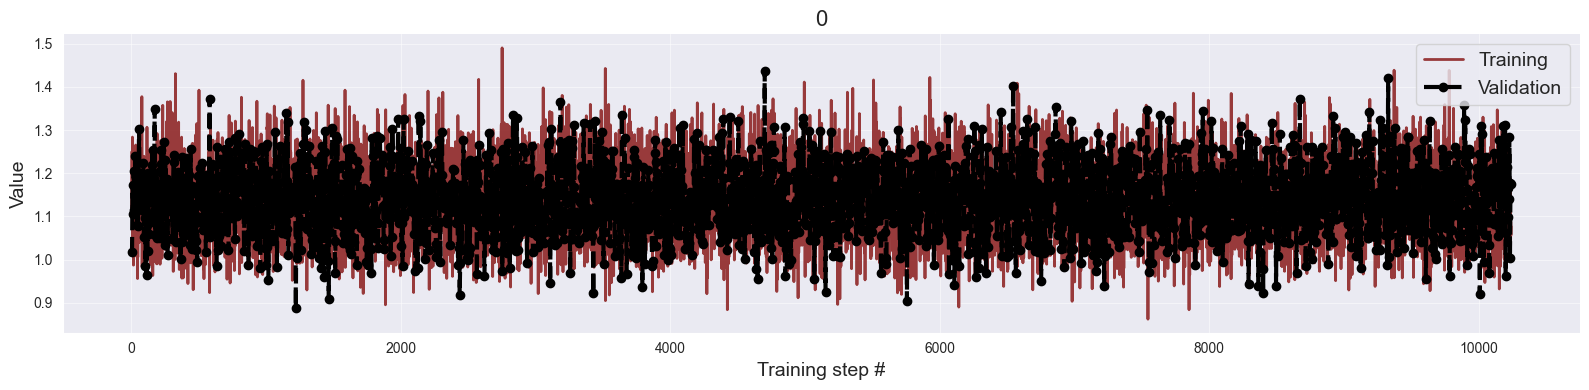

In [36]:
import pandas as pd

f = plot_losses(
    train_losses=pd.DataFrame(batch_loss_history.losses["training_loss"]), 
    val_losses=pd.DataFrame(batch_loss_history.losses["validation_loss"])
)

In [37]:
n_samples = 5000

conditions = {
    "x": np.array([[0.0, 0.0, 0.0, 0.0]]).astype(np.float32),
}

samples = approximator.sample(conditions=conditions, num_samples=n_samples)

theta_samples = samples["theta"]

In [38]:
theta_samples

array([[[-0.8272288 , -0.49605218,  0.70173615,  0.5919672 ],
        [-0.3977319 ,  0.29412413,  0.4869203 , -0.6501034 ],
        [ 0.36272183, -0.808805  ,  0.0503429 , -0.8143094 ],
        ...,
        [ 0.44116256,  0.22608528,  0.08759339,  1.1507258 ],
        [-0.14893901, -0.90049297,  0.67143995, -0.46183816],
        [ 0.05667248,  0.3298449 ,  0.0929981 , -0.47135326]]],
      dtype=float32)

In [39]:
prior_samples = simulator.sample(conditions=conditions, batch_shape=(n_samples,))

In [40]:
prior_theta_sample = np.zeros((1, n_samples, 4))
prior_theta_sample[0, :] = prior_samples['theta']

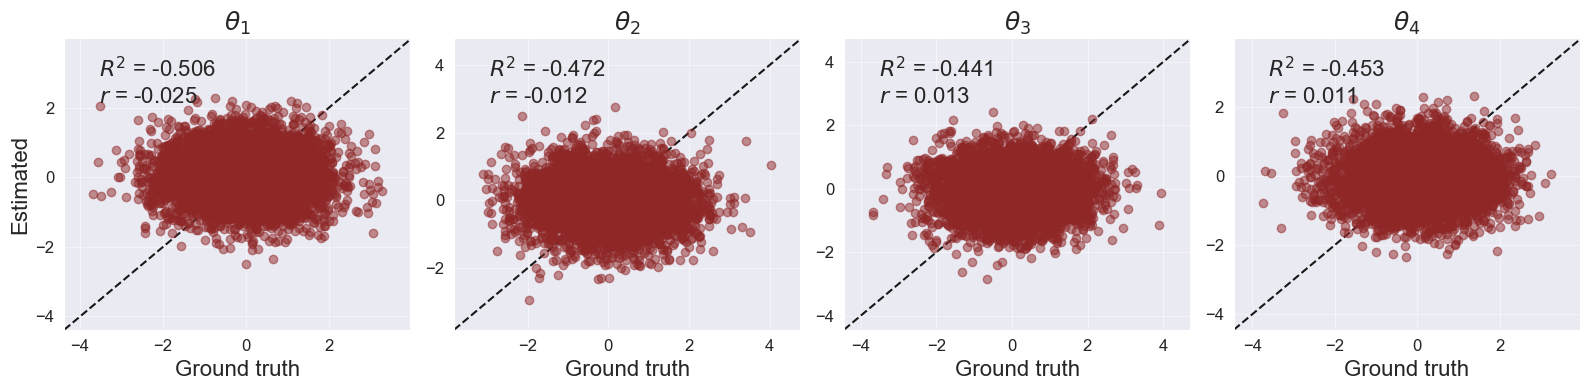

In [41]:
f = plot_recovery(
    post_samples=np.swapaxes(theta_samples, 0, 1), 
    prior_samples=prior_samples['theta']
)